In [134]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [88]:
cells_loops = pd.read_csv('tracked_centroids_loops_added.csv', sep=';')

# round the intensity column to 4 decimal places
cells_loops.intensity = np.round(cells_loops.intensity.values, 4)

In [34]:
nonzero = np.nonzero(cells_loops.in_loop.values)

# mean intensity of cells that are inside loops
print(np.mean(cells_loops[cells_loops.in_loop > 0.5].intensity))

# mean intenisty of cells that are not inside loops
print(np.mean(cells_loops[cells_loops.in_loop == 0].intensity))


0.06365599999999999
0.10145718992704167


In [32]:
for idx, cell in cells_loops.groupby('particle'):
    print(idx, round(np.sum(np.gradient(cell.intensity)), 5))

0 0.004
1 -0.0905
2 -0.00525
3 0.007
5 0.00145
6 0.00475
7 0.02865
8 0.02345
15 0.21415
20 -0.0485
21 -0.0149
24 0.00525
25 0.0316
28 0.01615
32 0.03125
34 -0.00355
35 0.02985
36 -0.02435
37 0.136
45 -0.0009
46 0.0033
48 0.2919
54 0.02955
59 0.00595
61 0.0755
62 0.0046
64 -0.0188
67 -0.00195
71 0.0479
72 0.0806
73 0.0156
74 0.0392
76 0.0259
79 0.0774
80 0.00745
81 -0.00185
82 -0.06895
83 -0.17015
85 0.018
88 -0.009
90 -0.0033
91 -0.16645
92 0.01055
93 -0.0799
94 0.0265
96 -0.04035
97 -0.29845
98 -0.014
99 -0.1195
100 -0.03225
101 0.0125
102 -0.0119
103 0.0218
104 -0.05685
105 0.10155
106 -0.13095
107 -0.0115
108 0.0001
109 -0.0078
110 -0.09395
111 -0.0366
113 0.37325
114 -0.02475
115 -0.0405
116 -0.02455
117 0.09675
118 -0.05095
119 0.0788
120 -0.0672
121 -0.0193
122 0.051
123 0.1081
124 0.05225
125 -0.09995
127 0.10945
128 -0.0476
129 0.0435
130 -0.02575
131 0.26265
132 0.00415
133 -0.2298
134 -0.11355
136 0.0489
137 -0.0232
138 -0.14475
139 -0.05945
140 -0.07145
142 0.1118
143 0.1939

### Create 'beta' column

The columns in the csv file are the following

timepoint

cell_id

x (the x, y, z are coordinates of the cell center)

y

z

mask

intensity (mean pixel intensity of the detected mask)

inside_loop (is the cell, at this timepoint, inside a loop?)

dist_loop (what is the distance from the cell to the nearest coordinate of a loop boundary? either of the loop the cell is inside of, or if the cell isn't inside a loop, then distance to the nearest loop)

beta (is this a beta cell? i.e. does it go from dim to bright? this field can take three values: 0 for always dim, 1 for goes from dim to bright, and 2 for it is always bright)

turning_point (is this the timepoint for which the cell turned from dim to bright? or bright to dim?)

In [133]:
# create 'beta' column
cells_loops_cp = cells_loops.copy()
particles = [item[1] for item in cells_loops_cp.groupby('particle')]
always_bright = [np.all(cell.intensity > 0.2) for cell in particles]
always_id = [np.unique(cell.particle) for cell, idxbool in zip(particles, always_bright)
                                if idxbool]

dim_to_bright = [np.all(np.sum(np.gradient(cell.intensity)) > 0) & \
                         (cell.intensity.iloc[0] < cell.intensity.iloc[-1])
                 for cell in particles]
dim_to_bright_id = [np.unique(cell.particle) for cell, idxbool in zip(particles, dim_to_bright)
                                if idxbool]

bright_to_dim = [np.all(np.sum(np.gradient(cell.intensity)) < 0) & \
                            (cell.intensity.iloc[0] > cell.intensity.iloc[-1])
                    for cell in particles]
bright_to_dim_id = [np.unique(cell.particle) for cell, idxbool in zip(particles, bright_to_dim)
                                if idxbool]

always_bool = cells_loops_cp.particle.isin(always_id)
dim_to_bright_bool = cells_loops_cp.particle.isin(dim_to_bright_id) & (~always_bool)
bright_to_dim_bool = (cells_loops_cp.particle.isin(bright_to_dim_id) &
                         (~always_bool) & (~dim_to_bright_bool))

conditions = (
        dim_to_bright_bool,
        always_bool,
)

cells_loops_cp['beta'] = np.select(conditions, (1, 2))


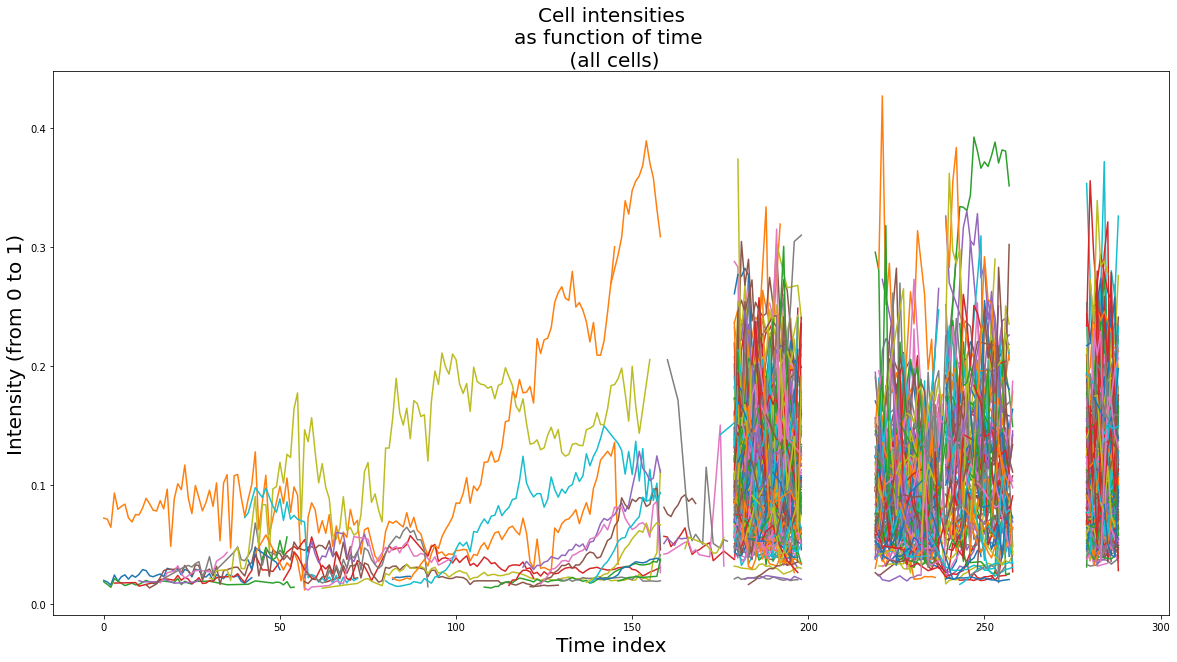

In [137]:
plt.figure(figsize=(20, 10))
plt.title('Cell intensities\nas function of time \n (all cells)', fontsize=20)
plt.xlabel('Time index', fontsize=20)
plt.ylabel('Intensity (from 0 to 1)', fontsize=20)

for idx, cell_traj in cells_loops.groupby('particle'):
    x = cell_traj.frame.values
    y = cell_traj.intensity.values
    if np.random.rand() > 0.0:
        plt.plot(x, y)
